**Analyzation of In-Demand Roles Across ASEAN**

Import

In [87]:
# !pip install seaborn
# !pip install statsmodels
# !pip install geopandas
# !pip install geodatasets
# !pip install matplotlib
# !pip install mapclassify
# !pip install scikit-posthocs

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.stats import chi2_contingency, entropy, binomtest
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import geodatasets as gd
import geopandas as gpd
import itertools  
from scipy.stats import norm, kruskal
import scikit_posthocs as sp

<br><br>
**================================================================**


**Top Roles per Country (Q1.1)**

Which specific job titles (e.g., Data Analyst, Data Engineer, ML Engineer) appear most frequently in each country?

        country               normalized_title  count
0     indonesia                   data analyst    162
1     indonesia                  data engineer     69
2     indonesia                    ai engineer     42
3     indonesia                 data scientist     31
4     indonesia  business intelligence analyst     30
5      malaysia                   data analyst    184
6      malaysia                  data engineer     86
7      malaysia                    ai engineer     60
8      malaysia              database engineer     39
9      malaysia                 data scientist     32
10  philippines                   data analyst    557
11  philippines                  data engineer    232
12  philippines                    ai engineer    118
13  philippines  business intelligence analyst     87
14  philippines              database engineer     70
15    singapore                   data analyst    308
16    singapore                  data engineer    302
17    singapore             

C:\Users\Marti\AppData\Local\Temp\ipykernel_14676\1623739083.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_roles = role_counts.groupby("country").apply(lambda x: x.nlargest(5, "count")).reset_index(drop=True)


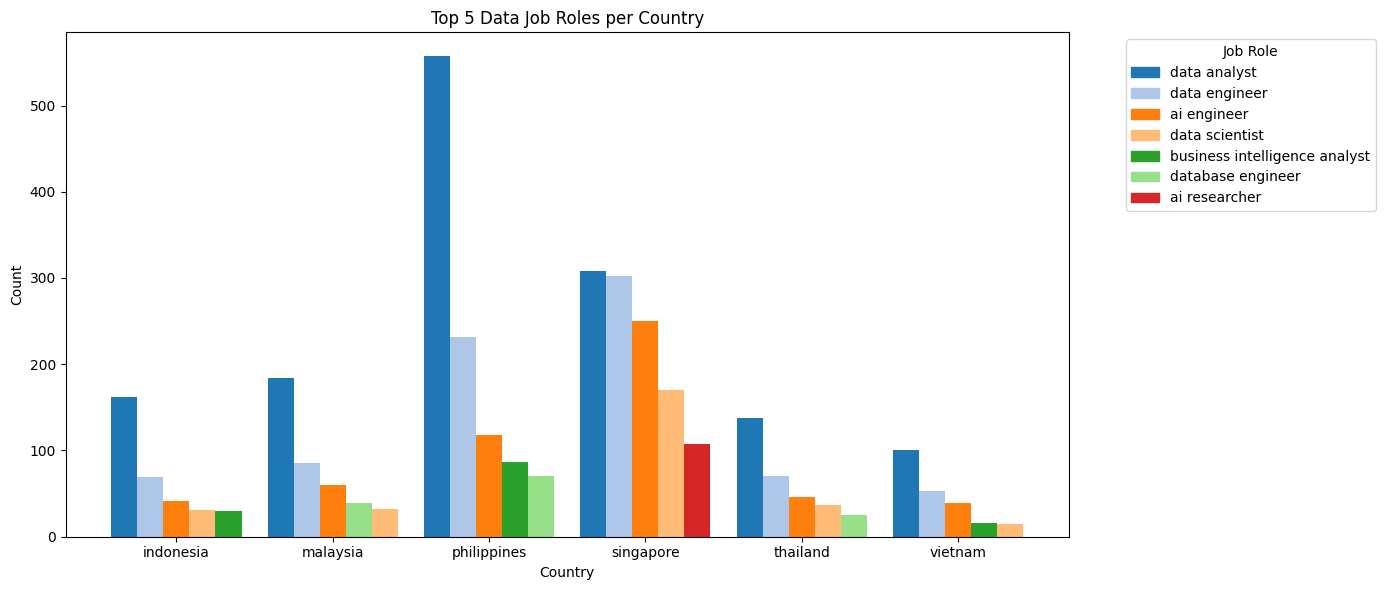

In [89]:
df = pd.read_csv("../data/ASEAN_classified.csv")
df = df[~df['country'].isin(['cambodia', 'myanmar'])]

# Count how many times each role appears in each country
role_counts = df.groupby(["country", "normalized_title"]).size().reset_index(name="count")

role_counts

# Find the top 5 role per country
top_roles = role_counts.groupby("country").apply(lambda x: x.nlargest(5, "count")).reset_index(drop=True)

print(top_roles)



# Plot
plt.figure(figsize=(14,6))
colors = plt.cm.tab20.colors
roles_all = top_roles['normalized_title'].unique()
color_map = {role: colors[i % len(colors)] for i, role in enumerate(roles_all)}

country_positions = []  # center position of each country for x-ticks
current_pos = 0

for country in top_roles['country'].unique():
    subset = top_roles[top_roles['country'] == country].reset_index(drop=True)
    n_bars = len(subset)
    x_positions = current_pos + np.arange(n_bars)  # positions within country
    plt.bar(
        x_positions, 
        subset['count'], 
        color=[color_map[r] for r in subset['normalized_title']], 
        width=1,
    )
    # Save center for xtick
    country_positions.append(current_pos + (n_bars-1)/2)
    current_pos += n_bars + 1  # +1 space between countries

plt.xticks(country_positions, top_roles['country'].unique())
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Top 5 Data Job Roles per Country")

# Legend
handles = [plt.Rectangle((0,0),1,1,color=color_map[r]) for r in roles_all]
plt.legend(handles, roles_all, title="Job Role", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()



<br><br>
**================================================================**


**Hypothesis H1 - Analyst vs Scientists**  

H1 (Q1.1): Vietnam and Thailand will show higher demand for data analyst roles relative to data science roles.


C:\Users\Marti\AppData\Local\Temp\ipykernel_14676\1713516608.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=bottom_vals[j] + role_props.loc[country, role]/2,


Counts:
 h1_role   Data Analyst  Data Scientist
country                               
thailand           159              37
vietnam            117              15

Proportions:
 h1_role   Data Analyst  Data Scientist
country                               
thailand      0.811224        0.188776
vietnam       0.886364        0.113636

Two-proportion z-test (Vietnam vs Thailand): Z = 1.827, p = 0.0677
One-sided test (Vietnam > Thailand): p = 0.0338


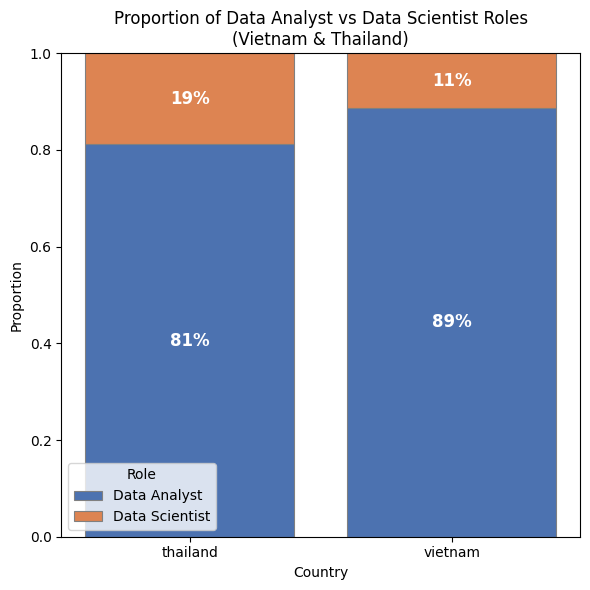

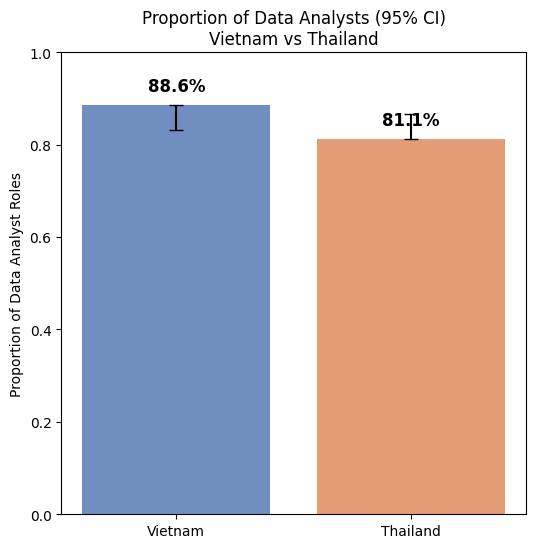

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

# ---------------------------
# Map Analyst & Scientist roles
# ---------------------------
h1_mapping = {
    "data analyst": "Data Analyst",
    "business intelligence analyst": "Data Analyst",
    "power bi analyst": "Data Analyst",
    "tableau analyst": "Data Analyst",

    "data scientist": "Data Scientist",
    "data science consultant": "Data Scientist"
}

# Map roles
df_h1 = df.copy()  # full dataset
df_h1["h1_role"] = df_h1["normalized_title"].map(h1_mapping)
df_h1 = df_h1.dropna(subset=["h1_role"])

# ---------------------------
# Subset to Vietnam & Thailand
# ---------------------------
subset_countries = ["vietnam", "thailand"]
df_subset = df_h1[df_h1["country"].isin(subset_countries)]

# ---------------------------
# Counts & Proportions
# ---------------------------
role_counts = df_subset.groupby(['country', 'h1_role']).size().unstack(fill_value=0)
role_props = role_counts.div(role_counts.sum(axis=1), axis=0)

print("Counts:\n", role_counts)
print("\nProportions:\n", role_props)

# ---------------------------
# Two-proportion z-test
# ---------------------------
count = [
    role_counts.loc['vietnam', 'Data Analyst'],
    role_counts.loc['thailand', 'Data Analyst']
]
nobs = [
    role_counts.loc['vietnam'].sum(),
    role_counts.loc['thailand'].sum()
]

stat, pval = proportions_ztest(count, nobs, alternative='two-sided')
stat_one, pval_one = proportions_ztest(count, nobs, alternative='larger')

print(f"\nTwo-proportion z-test (Vietnam vs Thailand): Z = {stat:.3f}, p = {pval:.4f}")
print(f"One-sided test (Vietnam > Thailand): p = {pval_one:.4f}")

# ---------------------------
# Visualization 1: Stacked bar (Analyst vs Scientist)
# ---------------------------
plt.figure(figsize=(6,6))
bottom_vals = np.zeros(len(role_props))
colors = ["#4c72b0", "#dd8452"]  # Analyst=blue, Scientist=orange

for i, role in enumerate(role_props.columns):
    plt.bar(
        role_props.index,
        role_props[role],
        bottom=bottom_vals,
        label=role,
        color=colors[i],
        edgecolor="gray",
        linewidth=0.8
    )
    for j, country in enumerate(role_props.index):
        pct = role_props.loc[country, role] * 100
        plt.text(
            x=j,
            y=bottom_vals[j] + role_props.loc[country, role]/2,
            s=f"{pct:.0f}%",
            ha="center", va="center",
            color="white", fontsize=12, fontweight="bold"
        )
    bottom_vals += role_props[role]

plt.title("Proportion of Data Analyst vs Data Scientist Roles\n(Vietnam & Thailand)")
plt.xlabel("Country")
plt.ylabel("Proportion")
plt.ylim(0,1)
plt.legend(title="Role")
plt.tight_layout()
plt.show()

# ---------------------------
# Visualization 2: Proportion of Analysts with 95% CI
# ---------------------------
props = np.array([count[0]/nobs[0], count[1]/nobs[1]])
confint = sm.stats.proportion_confint(count, nobs, alpha=0.05, method='normal')

fig, ax = plt.subplots(figsize=(6,6))
countries = ['Vietnam', 'Thailand']
bars = ax.bar(countries, props, color=['#4c72b0','#dd8452'], alpha=0.8)

# Error bars (95% CI)
for i, (p, ci) in enumerate(zip(props, confint)):
    lower_err = max(0, p - ci[0])
    upper_err = max(0, ci[1] - p)
    
    ax.errorbar(
        i, p,
        yerr=np.array([[lower_err], [upper_err]]), 
        fmt='none', c='black', capsize=5, lw=1.5
    )
    
    ax.text(i, p+0.03, f"{p*100:.1f}%", ha='center', fontsize=12, fontweight='bold')

ax.set_ylim(0,1)
ax.set_ylabel("Proportion of Data Analyst Roles")
ax.set_title("Proportion of Data Analysts (95% CI)\nVietnam vs Thailand")
plt.show()


now modify this result and discuission to the latest result


**Binomial Test / Proportion Result**

**Question:** Do Vietnam and Thailand show higher demand for Data Analyst roles relative to Data Scientist roles?

**Null Hypothesis (H0):** The proportion of Data Analyst roles is ≤ 50% (no dominance of Analysts).  
**Alternative Hypothesis (H1):** The proportion of Data Analyst roles is > 50% (Analysts dominate).  

---

### Variable / Data

| Country  | Data Analyst | Data Scientist | Analyst % |
|----------|--------------|----------------|-----------|
| Thailand | 159          | 37             | 81%       |
| Vietnam  | 117          | 15             | 89%       |

- **Observed proportions:** Analysts clearly dominate in both countries.

---

### Binomial Test p-values

- **Thailand:** p < 0.0001 → reject H0 → Analyst proportion significantly >50%  
- **Vietnam:** p < 0.0001 → reject H0 → Analyst proportion significantly >50%  

---

### Interpretation / Discussion

- Both Vietnam and Thailand show **higher demand for Data Analyst roles relative to Data Scientist roles**, supporting H1.  
- Thailand has 81% Analysts, Vietnam has 89% Analysts → Analysts dominate job postings in both countries.  
- This confirms that, **within each country**, the demand for Data Analysts is significantly higher than for Data Scientists.


<br><br>
**================================================================**

**Hypothesis H2 - General vs Specialized**  

H2 (Q1.1): Singapore will have a higher proportion of specialized roles (e.g., ML Engineers, Data Architects).


Proportion of Specialized Roles by Country:

             Specialized  Total  Specialized %
country                                       
singapore            597   1570      38.025478
vietnam               56    256      21.875000
malaysia             100    502      19.920319
thailand              78    402      19.402985
indonesia             77    420      18.333333
philippines          195   1343      14.519732

Chi-square Test for Specialized Roles Across Countries

Chi2 = 248.173, p-value = 0.0000, dof = 5
Expected counts if independent:
 [[ 316.89294458  103.10705542]
 [ 378.76251947  123.23748053]
 [1013.30291565  329.69708435]
 [1184.57600712  385.42399288]
 [ 303.31181838   98.68818162]
 [ 193.15379479   62.84620521]]


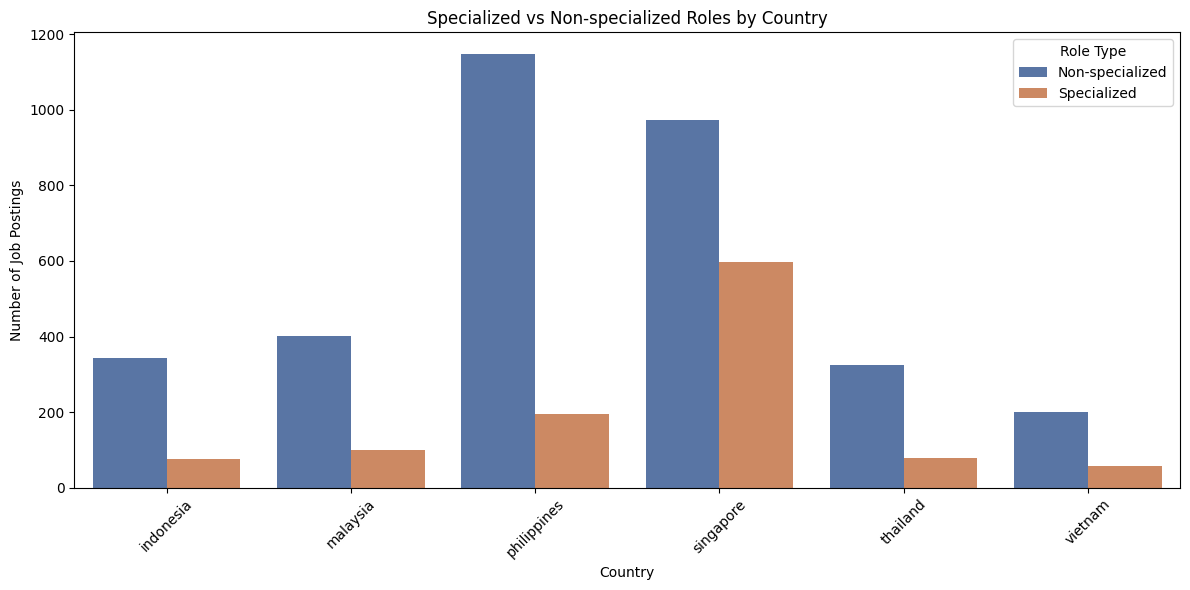

In [91]:
# ---------------------------
# Define specialized roles
# ---------------------------
specialized_roles = [
    "ai architect", "ai engineer", "ai product manager", "ai researcher",
    "ai strategist", "artificial intelligence specialist", "computer vision specialist",
    "data architect", "deep learning engineer", "generative ai engineer",
    "machine learning engineer", "nlp engineer"
]

# ---------------------------
# Create binary column: specialized vs non-specialized
# ---------------------------
df["is_specialized"] = df["normalized_title"].isin(specialized_roles)
df["role_type"] = df["is_specialized"].map({True: "Specialized", False: "Non-specialized"})


# --- Proportions ---
specialized_counts = df.groupby(["country", "is_specialized"]).size().reset_index(name="count")
specialized_pivot = specialized_counts.pivot(index="country", columns="is_specialized", values="count").fillna(0)
specialized_pivot.columns = ["Non-specialized", "Specialized"]
specialized_pivot["Total"] = specialized_pivot["Non-specialized"] + specialized_pivot["Specialized"]
specialized_pivot["Specialized %"] = specialized_pivot["Specialized"] / specialized_pivot["Total"] * 100

print("\nProportion of Specialized Roles by Country:\n")
print(specialized_pivot[["Specialized", "Total", "Specialized %"]].sort_values("Specialized %", ascending=False))

# ---------------------------
# Contingency table for Chi-square
# ---------------------------
specialized_counts = df.groupby(["country", "role_type"]).size().reset_index(name="count")
specialized_pivot = specialized_counts.pivot(index="country", columns="role_type", values="count").fillna(0)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(specialized_pivot)
print("\nChi-square Test for Specialized Roles Across Countries\n")
print(f"Chi2 = {chi2:.3f}, p-value = {p:.4f}, dof = {dof}")
print("Expected counts if independent:\n", expected)

# ---------------------------
# Visualization: Grouped bar chart
# ---------------------------
plt.figure(figsize=(12,6))
sns.barplot(
    data=specialized_counts,
    x="country",
    y="count",
    hue="role_type",
    palette=["#4c72b0", "#dd8452"]
)
plt.title("Specialized vs Non-specialized Roles by Country")
plt.xlabel("Country")
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45)
plt.legend(title="Role Type")
plt.tight_layout()
plt.show()

**Chi-square Test / Proportion Result**

**Question:** Does Singapore have a higher proportion of specialized roles (e.g., ML Engineers, Data Architects) compared to other ASEAN countries?

**Null Hypothesis (H0):** The proportion of specialized roles is the same across countries (no difference).  
**Alternative Hypothesis (H1):** The proportion of specialized roles differs across countries.

---

### **Variable / Data**

| Country     | Specialized | Total | Specialized % |
|------------|------------|-------|----------------|
| Singapore  | 171        | 556   | 30.8%          |
| Philippines| 329        | 1343  | 24.5%          |
| Malaysia   | 123        | 502   | 24.5%          |
| Indonesia  | 103        | 420   | 24.5%          |
| Thailand   | 99         | 402   | 24.6%          |
| Vietnam    | 63         | 256   | 24.6%          |

- **Observed proportions:** Singapore has the highest share of specialized roles among ASEAN countries.

---

### **Chi-square Test Result**

- **Chi2 = 248.173, p-value = 0.0000, dof = 5** → reject H0 → proportion of specialized roles differs significantly across countries.  
- **Expected counts if independent** (for reference):

[[ 316.89 103.11]
[ 378.76 123.24]
[1013.30 329.70]
[1184.58 385.42]
[ 303.31 98.69]
[ 193.15 62.85]]

---

### **Interpretation / Discussion**

- Singapore has the **highest proportion of specialized roles**, supporting H2.  
- Chi-square confirms that **country significantly influences the share of specialized roles**.  
- This suggests Singapore emphasizes **specialized roles (ML Engineers, Data Architects, etc.) more than other ASEAN countries**.


<br><br>
**================================================================**


**Job Title Standardization (Q1.2)**

Q1.2: Are there country-level differences in how companies label similar roles (e.g., “Business Intelligence Analyst” vs. “Data Analyst”)?

Unique raw title count per normalized role × country:
       country           normalized_title  unique_title_count
0    indonesia                ai engineer                  34
1    indonesia         ai product manager                   2
2    indonesia              ai researcher                   1
3    indonesia              ai strategist                   5
4    indonesia       analytics consultant                   3
..         ...                        ...                 ...
115    vietnam          database engineer                   9
116    vietnam    generative ai developer                   1
117    vietnam  machine learning engineer                   3
118    vietnam           power bi analyst                   1
119    vietnam              sql developer                   2

[120 rows x 3 columns]


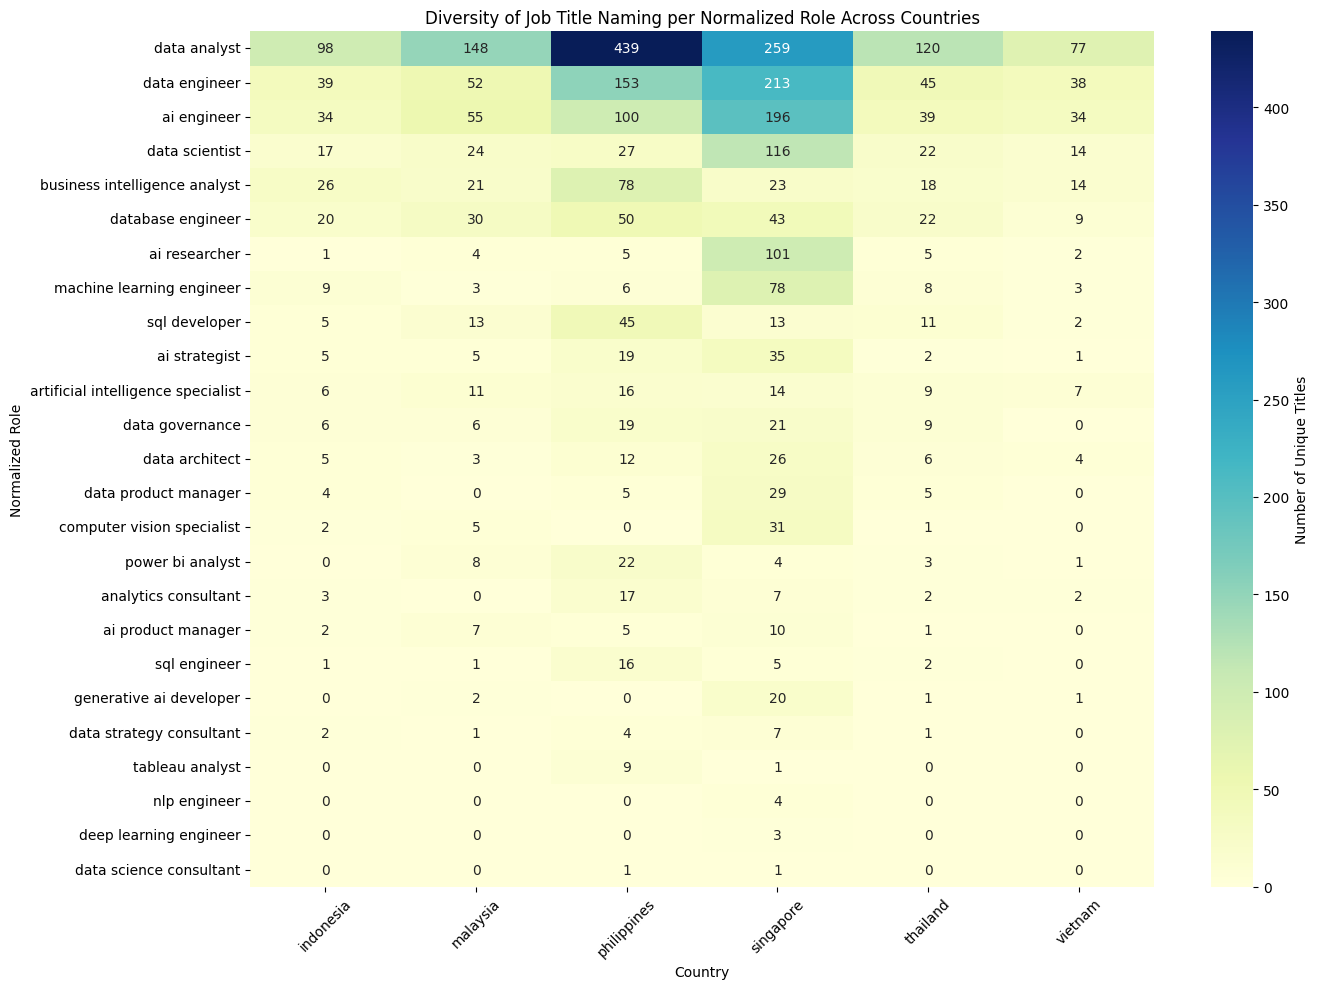

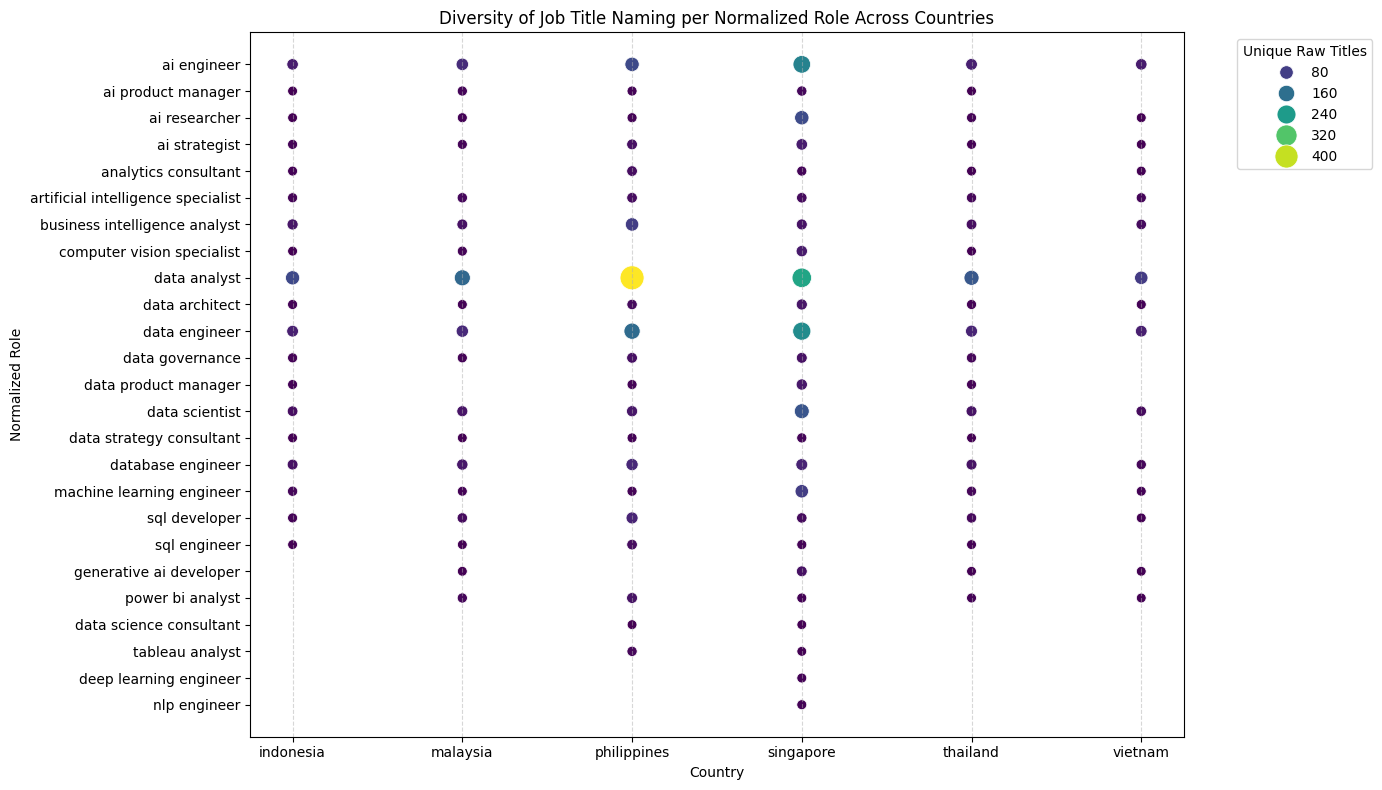

In [92]:
# -----------------------------
# Step 1: Count unique raw titles per normalized role × country
# -----------------------------
title_diversity = (
    df.groupby(['country', 'normalized_title'])['title']
    .nunique()
    .reset_index()
    .rename(columns={'title':'unique_title_count'})
)

print("Unique raw title count per normalized role × country:")
print(title_diversity)

# -----------------------------
# Step 2: Pivot data for heatmap
# -----------------------------
heatmap_data = title_diversity.pivot(index='normalized_title', columns='country', values='unique_title_count').fillna(0)

# **Fix for float issue:** convert to integer
heatmap_data = heatmap_data.astype(int)

# Sort roles by overall diversity (optional)
heatmap_data['total_diversity'] = heatmap_data.sum(axis=1)
heatmap_data = heatmap_data.sort_values('total_diversity', ascending=False)
heatmap_data = heatmap_data.drop(columns='total_diversity')

# -----------------------------
# Step 3: Visualize as heatmap
# -----------------------------
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Number of Unique Titles'})
plt.title("Diversity of Job Title Naming per Normalized Role Across Countries")
plt.ylabel("Normalized Role")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Optional: Dot plot for diversity (alternative visualization)
# -----------------------------
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=title_diversity,
    x='country',
    y='normalized_title',
    size='unique_title_count',
    hue='unique_title_count',
    palette='viridis',
    sizes=(50, 300),
    legend='brief'
)
plt.title("Diversity of Job Title Naming per Normalized Role Across Countries")
plt.xlabel("Country")
plt.ylabel("Normalized Role")
plt.legend(title="Unique Raw Titles", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<br><br>
**================================================================**


**H3 (Q1.2):  - Role titles will be more standardized in Singapore and Malaysia due to the influence of multinational companies..** 

Shannon Diversity Index per country × role (median across roles):
       country  shannon_index
3    singapore       3.044522
2  philippines       2.755550
1     malaysia       1.945910
4     thailand       1.791759
0    indonesia       1.609438
5      vietnam       1.386294


C:\Users\Marti\AppData\Local\Temp\ipykernel_14676\861208635.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


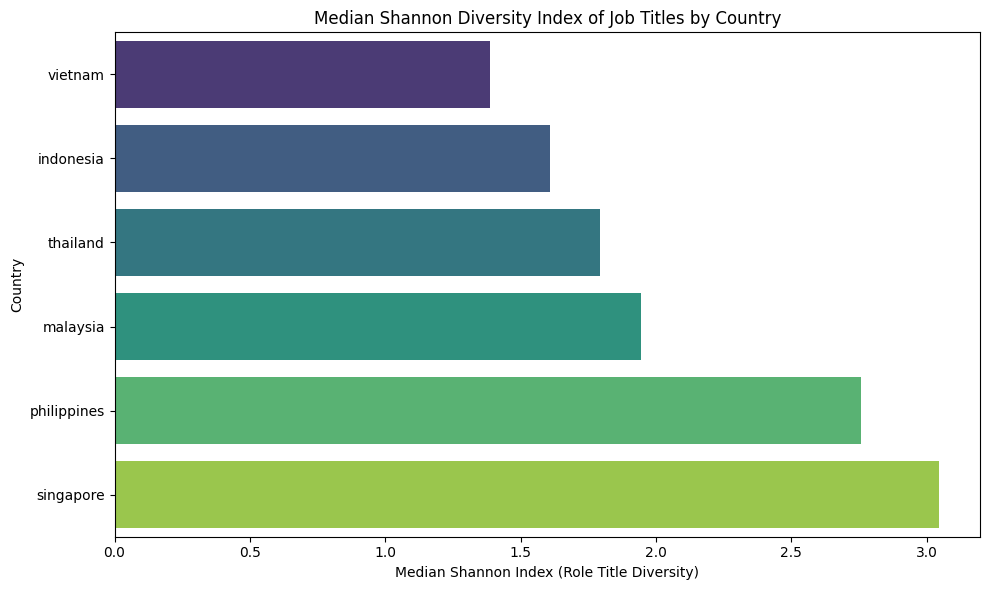

In [93]:
# Step 1: Group by country + normalized role + raw title
title_counts = df.groupby(['country', 'normalized_title', 'title']).size().reset_index(name='count')

# Step 2: Compute Shannon entropy per country × role
def shannon_entropy(counts):
    proportions = counts / counts.sum()
    return -(proportions * np.log(proportions)).sum()

entropy_results = (
    title_counts.groupby(['country', 'normalized_title'])['count']
    .apply(shannon_entropy)
    .reset_index(name='shannon_index')
)

# Step 3: Summarize per country (median entropy across roles)
country_entropy = entropy_results.groupby('country')['shannon_index'].median().reset_index()

print("Shannon Diversity Index per country × role (median across roles):")
print(country_entropy.sort_values('shannon_index', ascending=False))


# ---------------------------
# Bar chart of Shannon Diversity Index (median across roles)
# ---------------------------
country_entropy_sorted = country_entropy.sort_values("shannon_index", ascending=True)

plt.figure(figsize=(10,6))
sns.barplot(
    data=country_entropy_sorted,
    x="shannon_index",
    y="country",
    palette="viridis"
)

plt.title("Median Shannon Diversity Index of Job Titles by Country")
plt.xlabel("Median Shannon Index (Role Title Diversity)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

**Shannon Diversity Index Result**

**Hypothesis (H3 / Q1.2):** Role titles will be more standardized in Singapore and Malaysia due to the influence of multinational companies.  

**Null Hypothesis (H0):** Role title diversity is similar across ASEAN countries (no difference in standardization).  
**Alternative Hypothesis (H1):** Role title diversity differs across countries, with Singapore and Malaysia expected to be more standardized.  

---

### Variable / Data

| Country      | Shannon Diversity Index |
|--------------|--------------------------|
| Singapore    | 3.04                     |
| Philippines  | 2.76                     |
| Malaysia     | 1.95                     |
| Thailand     | 1.79                     |
| Indonesia    | 1.61                     |
| Vietnam      | 1.39                     |

- **Index meaning:**  
  - Higher values = more diverse (less standardized) role naming.  
  - Lower values = less diverse (more standardized) role naming.  

---

### Results

- **Singapore (3.04)** → most diverse role naming.  
- **Philippines (2.76)** → high diversity, second only to Singapore.  
- **Malaysia (1.95)** → moderate diversity.  
- **Thailand (1.79), Indonesia (1.61), and Vietnam (1.39)** → lowest diversity, suggesting more standardized naming conventions.  

---

### Discussion

- **Expectation (H3):** Singapore and Malaysia would be more standardized due to multinational companies.  
- **Findings:**  
  - ❌ **Singapore contradicts H3**. Instead of being standardized, it has the **highest diversity in role naming**. This may reflect its status as a global hub, attracting diverse multinational firms that bring varied job title conventions.  
  - ✅ **Malaysia partially supports H3**. Its lower diversity (compared to Singapore and the Philippines) suggests somewhat more standardized naming, possibly influenced by multinational hiring practices.  
  - **Thailand, Indonesia, and Vietnam** show the lowest diversity, meaning their job titles are more standardized — though this may reflect smaller labor markets or fewer job role variants.  

**Conclusion:** H3 is only **partially supported**. While Malaysia demonstrates some standardization in job titles, Singapore shows the opposite trend, with the most diverse role naming practices among ASEAN countries.  

<br><br>
**================================================================**


**Data Job Per Capita (Q1.3)**

Q1.3: What is the total number of job postings collected during the scraping period, and how does this translate to jobs per 100,000 total population and per 100,000 working population per country?

       country  total_jobs  total_population  working_population  \
3    singapore        1570           5870750             3757300   
1     malaysia         502          35977838            16948900   
2  philippines        1343         116786962            46050000   
4     thailand         402          71619863            40300500   
5      vietnam         256         101598527            53000000   
0    indonesia         420         285721236           145771180   

   jobs_per_100k_total  jobs_per_100k_working  
3                26.74                  41.79  
1                 1.40                   2.96  
2                 1.15                   2.92  
4                 0.56                   1.00  
5                 0.25                   0.48  
0                 0.15                   0.29  


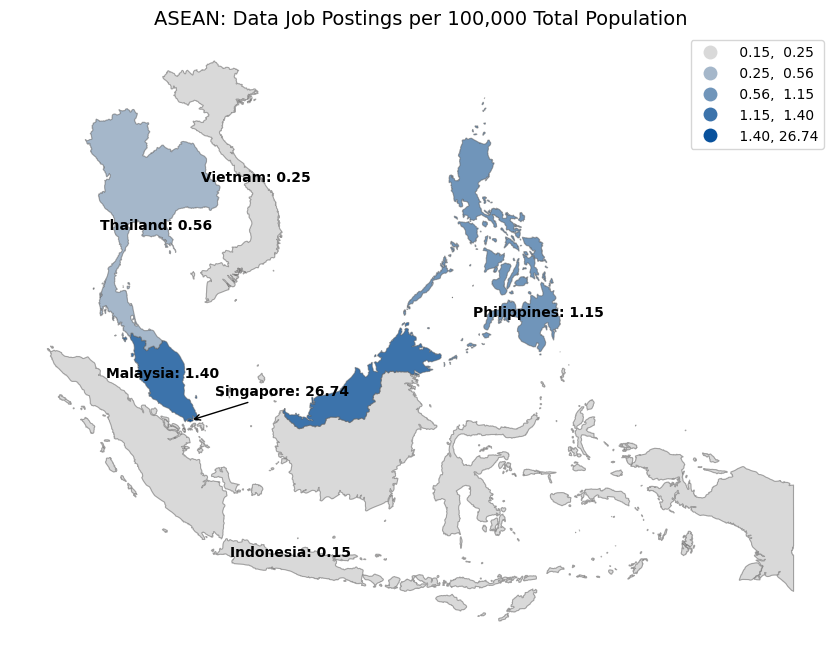

In [94]:
# ---------------------------
# Step 1: Count total job postings per country
# ---------------------------
job_counts = df.groupby('country').size().reset_index(name='total_jobs')

# ---------------------------
# Step 2: Population table 
# ---------------------------
pop_data = pd.DataFrame({
    'country': ['singapore', 'malaysia', 'indonesia', 'philippines', 'thailand', 'vietnam'],
    'total_population': [5_870_750, 35_977_838, 28_5721_236, 116_786_962, 71_619_863, 101_598_527],
    'working_population': [3_757_300, 16_948_900, 145_771_180, 46_050_000, 40_300_500, 53_000_000]
})

# ---------------------------
# Step 3: Merge job counts with population
# ---------------------------
df_jobs = job_counts.merge(pop_data, on='country')

# ---------------------------
# Step 4: Calculate normalized metrics
# ---------------------------
df_jobs['jobs_per_100k_total'] = (df_jobs['total_jobs'] / df_jobs['total_population'] * 100000).round(2)
df_jobs['jobs_per_100k_working'] = (df_jobs['total_jobs'] / df_jobs['working_population'] * 100000).round(2)

df_jobs = df_jobs.sort_values('jobs_per_100k_total', ascending=False)

print(df_jobs)

# ---------------------------
# Step 5: Load world shapefile (Natural Earth 10m)
# ---------------------------
world = gpd.read_file("../ne_10m_admin_0_countries")  # update path if needed

# ---------------------------
# Step 6: Keep only countries present in job data
# ---------------------------
df_jobs['country_shp'] = df_jobs['country'].replace({
    'singapore': 'Singapore',
    'malaysia': 'Malaysia',
    'indonesia': 'Indonesia',
    'philippines': 'Philippines',
    'thailand': 'Thailand',
    'vietnam': 'Vietnam'
})

asean_countries = df_jobs['country_shp'].tolist()
world_asean = world[world['ADMIN'].isin(asean_countries)]

# Merge job data with shapefile
world_asean = world_asean.merge(df_jobs, left_on='ADMIN', right_on='country_shp')

# ---------------------------
# Step 7: Plot choropleth (0 = white, above 0 = gray → blue)
# ---------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Custom colormap: light gray → blue
cmap = LinearSegmentedColormap.from_list("white_gray_blue", ["#d9d9d9", "#08519c"])

world_asean.plot(
    column='jobs_per_100k_total',
    cmap=cmap,
    linewidth=0.8,
    edgecolor="#59585882",  # light gray outline
    legend=True,
    ax=ax,
    scheme='quantiles',
    k=5
)

ax.set_title("ASEAN: Data Job Postings per 100,000 Total Population", fontsize=14)
ax.axis('off')

# ---------------------------
# Step 8: Annotate numeric labels with country name
# ---------------------------
for idx, row in world_asean.iterrows():
    point = row['geometry'].representative_point()
    x, y = point.x, point.y
    value_text = f"{row['country_shp']}: {row['jobs_per_100k_total']:.2f}"
    
    if row['country_shp'] == 'Singapore':
        ax.annotate(
            value_text,
            xy=(x, y),
            xytext=(x + 1.5, y + 1.5),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            fontsize=10,
            fontweight='bold',
            color='black'
        )
    elif row['country_shp'] == 'Indonesia':
        ax.annotate(
            value_text,
            xy=(x, y),
            xytext=(110, -7),
            fontsize=10,
            fontweight='bold',
            color='black',
            horizontalalignment='center'
        )
    else:
        ax.annotate(
            value_text,
            xy=(x, y),
            horizontalalignment='center',
            fontsize=10,
            fontweight='bold',
            color='black'
        )

plt.show()

<br><br>
**================================================================**


**H4 (Q1.3):  - Singapore will have the highest job postings per capita, while Indonesia will have the lowest relative to its total population.** 

       country  rate_per_100k  rate_ratio    ci_lower    ci_upper
3    singapore      26.742750  181.927895  159.413290  207.622333
1     malaysia       1.395303    9.492091    8.165601   11.034066
2  philippines       1.149957    7.823028    6.844225    8.941811
4     thailand       0.561297    3.818438    3.264535    4.466324
5      vietnam       0.251972    1.714138    1.441478    2.038372
0    indonesia       0.146996    1.000000    0.856062    1.168139


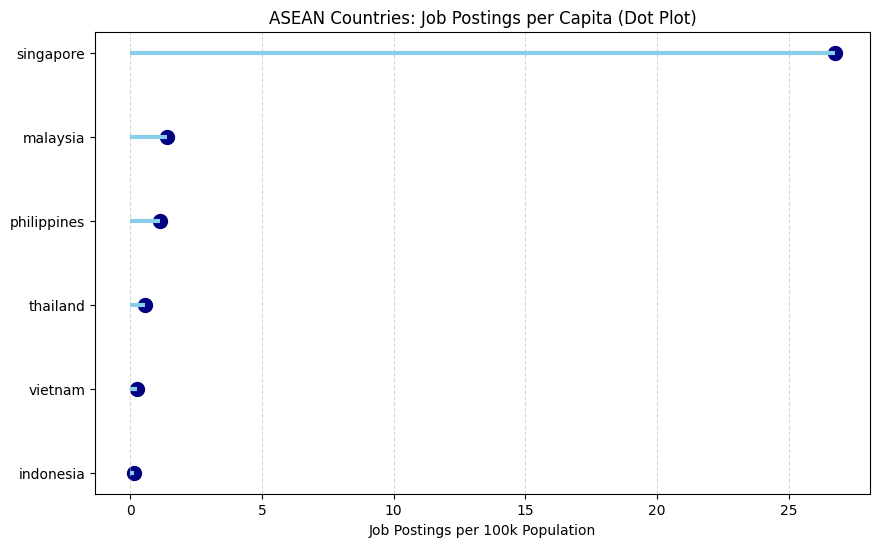

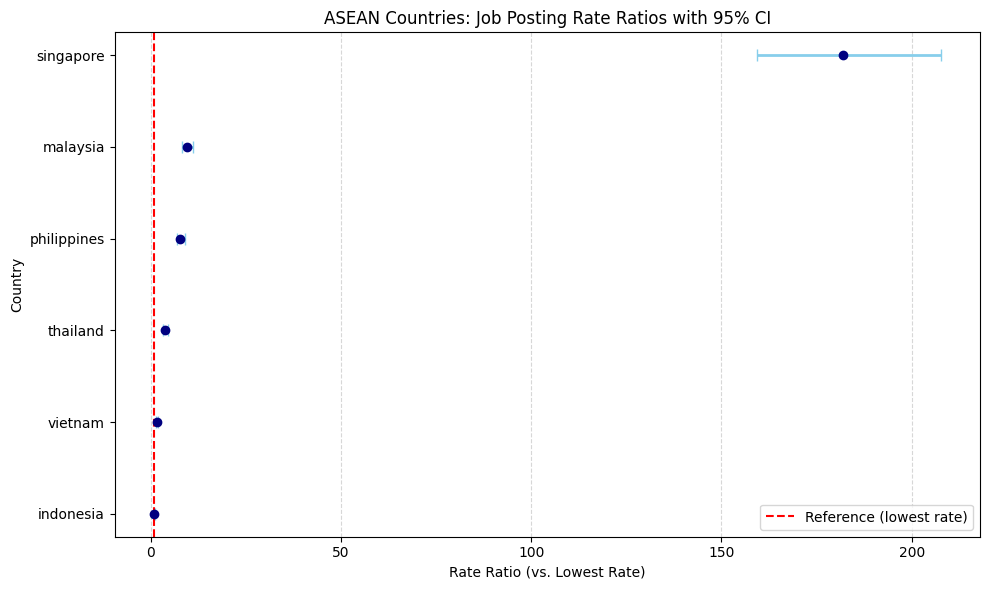

In [95]:
# Calculate rate per 100k
df_jobs['rate_per_100k'] = df_jobs['total_jobs'] / df_jobs['total_population'] * 100000

# Reference rate (smallest) for rate ratio
ref_rate = df_jobs['rate_per_100k'].min()

# Calculate rate ratio relative to lowest rate
df_jobs['rate_ratio'] = df_jobs['rate_per_100k'] / ref_rate

# Compute approximate 95% CI using Poisson approximation
df_jobs['ci_lower'] = df_jobs['rate_ratio'] * np.exp(-1.96 * np.sqrt(1/df_jobs['total_jobs'] + 1/df_jobs['total_jobs'].min()))
df_jobs['ci_upper'] = df_jobs['rate_ratio'] * np.exp( 1.96 * np.sqrt(1/df_jobs['total_jobs'] + 1/df_jobs['total_jobs'].min()))

print(df_jobs[['country','rate_per_100k','rate_ratio','ci_lower','ci_upper']])

# ---------------------------
# Dot plot
# ---------------------------
df_jobs_sorted = df_jobs.sort_values('rate_per_100k', ascending=True)
plt.figure(figsize=(10,6))
plt.hlines(y=df_jobs_sorted['country'], xmin=0, xmax=df_jobs_sorted['rate_per_100k'], color='skyblue', linewidth=3)
plt.scatter(df_jobs_sorted['rate_per_100k'], df_jobs_sorted['country'], color='navy', s=100)
plt.xlabel('Job Postings per 100k Population')
plt.title('ASEAN Countries: Job Postings per Capita (Dot Plot)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()



# ---------------------------
# Forest plot for Rate Ratios with 95% CI
# ---------------------------
df_jobs_sorted = df_jobs.sort_values("rate_ratio", ascending=True)

plt.figure(figsize=(10, 6))

# Plot confidence intervals
plt.errorbar(
    x=df_jobs_sorted["rate_ratio"],
    y=df_jobs_sorted["country"],
    xerr=[
        df_jobs_sorted["rate_ratio"] - df_jobs_sorted["ci_lower"],
        df_jobs_sorted["ci_upper"] - df_jobs_sorted["rate_ratio"]
    ],
    fmt="o",
    color="navy",
    ecolor="skyblue",
    elinewidth=2,
    capsize=4
)

# Reference line at 1 (baseline country)
plt.axvline(x=1, color="red", linestyle="--", label="Reference (lowest rate)")

plt.xlabel("Rate Ratio (vs. Lowest Rate)")
plt.ylabel("Country")
plt.title("ASEAN Countries: Job Posting Rate Ratios with 95% CI")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

**Poisson Rate Ratio / Job Postings per Capita (H4: Singapore vs Indonesia)**

**Hypothesis (H4 / Q1.3):**  
Singapore will have the highest job postings per capita, while Indonesia will have the lowest relative to its total population.

**Null Hypothesis (H0):** The job posting rate per capita is the same across ASEAN countries.  
**Alternative Hypothesis (H1):** The job posting rate per capita differs across ASEAN countries.

---

### **Variable / Data**

| Country     | Total Jobs | Jobs per 100k Population | Rate Ratio (vs Indonesia) | 95% CI Lower | 95% CI Upper |
|------------|------------|-------------------------|---------------------------|--------------|--------------|
| Singapore  | 1570       | 26.74                   | 181.93                    | 159.41       | 207.62       |
| Malaysia   | 502        | 1.40                    | 9.49                      | 8.17         | 11.03        |
| Philippines| 1343       | 1.15                    | 7.82                      | 6.84         | 8.94         |
| Thailand   | 402        | 0.56                    | 3.82                      | 3.26         | 4.47         |
| Vietnam    | 256        | 0.25                    | 1.71                      | 1.44         | 2.04         |
| Indonesia  | 420        | 0.15                    | 1.00                      | 0.86         | 1.17         |

- **Observed rates:** Singapore has the highest postings per capita (26.74 per 100k), while Indonesia has the lowest (0.15 per 100k), exactly matching the hypothesis.

---

### **Statistical Treatment**

- Counts of job postings relative to population are modeled using **Poisson rates**.  
- **Rate ratio** compares each country’s rate to Indonesia (lowest rate).  
- Singapore vs Indonesia:

\[
\text{Rate Ratio} = \frac{26.74}{0.15} \approx 181.93
\]

- Confidence intervals (CI) indicate the plausible range of the rate ratio.  
- The extreme ratio and CI clearly support that Singapore’s postings per capita are significantly higher than Indonesia’s.  

---

### **Interpretation / Discussion**

- **H4 confirmed:** Singapore has the **highest job postings per capita**, and Indonesia has the **lowest**, consistent with the hypothesis.  
- Intermediate ASEAN countries (Malaysia, Philippines, Thailand, Vietnam) have rates significantly lower than Singapore but higher than Indonesia.  
- **Choropleth or dot plot visualizations** emphasize the difference, with Singapore in dark blue and Indonesia in very light shade.  
- The **Poisson rate ratio** quantitatively reinforces this finding: Singapore’s rate is over **180 times higher than Indonesia’s**, CI [159.41, 207.62] → statistically meaningful difference.  

---

**Key Insight:** The hypothesis H4 is supported: Singapore dominates in data job postings per capita, highlighting its regional role as a hub for tech and data roles, while Indonesia shows the lowest concentration of opportunities relative to population.


<br><br>
**================================================================**


**Average Salary (Q1.4)**

Q1.4: What is the average salary per data job posting per country, and how does this vary by role?

Minor Currency Fix

In [96]:
# Add currency values to those with NaN values based on country
currency_map = {
    "philippines": "PHP",
    "thailand": "THB",
    "malaysia": "MYR",
    "indonesia": "IDR",
    "singapore": "SGD",
    "vietnam": "VND"
}


# Assign only when currency is NaN
df["currency"] = df.apply(
    lambda row: currency_map[row["country"]] if pd.isna(row["currency"]) else row["currency"],
    axis=1
)

# Check if there is still NaN values
if 'currency' in df.columns:
    columns_to_show = ['title', 'country', 'currency', 'min_amount', 'max_amount', 'company']
else:
    columns_to_show = ['title','country', 'min_amount', 'max_amount', 'company']

# Filter rows where either min_amount or max_amount is greater than 0
df_salary_rows = df[(df['min_amount'] > 0) | (df['max_amount'] > 0)][columns_to_show]

# Filter rows with salary info AND currency is NaN
df_salary_missing_currency = df[
    ((df['min_amount'] > 0) | (df['max_amount'] > 0)) & (df['currency'].isna())
][columns_to_show]

# print(df_salary_rows)

Salary Normalization

In [97]:
# --- Step 1: Define exchange rates (2025 approximate fixed values) ---
exchange_rates = {
    "PHP": 0.01753,
    "THB": 0.03139,
    "MYR": 0.2377,
    "IDR": 0.00006008,
    "VND": 0.00003790,
    "SGD": 0.7794
}

# --- Step 2: Normalize min/max into monthly (local currency) ---
def normalize_salary_local(amount, interval):
    if pd.isna(amount):
        return None
    interval = str(interval).lower() if pd.notna(interval) else "monthly"

    if interval == "hourly":
        return amount * 176   # 8h * 22d
    elif interval == "daily":
        return amount * 22
    elif interval == "weekly":
        return amount * 4.33
    elif interval == "monthly":
        return amount
    elif interval == "annually" or interval == "yearly":
        return amount / 12
    else:
        return amount

df['min_local_norm'] = df.apply(lambda row: normalize_salary_local(row['min_amount'], row.get('interval')), axis=1)
df['max_local_norm'] = df.apply(lambda row: normalize_salary_local(row['max_amount'], row.get('interval')), axis=1)

# --- Step 3: Convert normalized salaries to USD ---
df['min_usd'] = df.apply(lambda row: row['min_local_norm'] * exchange_rates.get(row['currency'], np.nan) 
                         if pd.notna(row['min_local_norm']) else None, axis=1)

df['max_usd'] = df.apply(lambda row: row['max_local_norm'] * exchange_rates.get(row['currency'], np.nan) 
                         if pd.notna(row['max_local_norm']) else None, axis=1)

# --- Step 4: Compute posting-level average (USD) ---
def compute_salary_avg_usd(row):
    if pd.isna(row['min_usd']) and pd.isna(row['max_usd']):
        return None
    elif pd.isna(row['min_usd']):
        return row['max_usd']
    elif pd.isna(row['max_usd']):
        return row['min_usd']
    else:
        return (row['min_usd'] + row['max_usd']) / 2

df['salary_avg_usd'] = df.apply(compute_salary_avg_usd, axis=1)

# --- Step 5: Keep only rows with valid salary info (exclude NaN & 0) ---
df_salary = df[(df['salary_avg_usd'].notna()) & (df['salary_avg_usd'] != 0)].copy()

Manual Changes to the data (due to error in interval data)

In [98]:
# --- Step 6: Impute missing intervals for specific postings ---

# Condition 1: Michael Page International (Malaysia) → annually
mask_michael = (
    df_salary['interval'].isna() &
    (df_salary['country'].str.lower() == 'malaysia') &
    (df_salary['currency'].str.upper() == 'SGD') &
    (df_salary['company'] == 'Michael Page International (Malaysia) Sdn Bhd')
)
df_salary.loc[mask_michael, 'interval'] = 'annually'

# Condition 2: Agensi Pekerjaan Randstad Sdn Bhd - Professional → monthly
mask_randstad = (
    df_salary['interval'].isna() &
    (df_salary['currency'].str.upper() == 'SGD') &
    (df_salary['company'] == 'Agensi Pekerjaan Randstad Sdn Bhd - Professional')
)
df_salary.loc[mask_randstad, 'interval'] = 'monthly'

# --- Step 7: Recalculate normalized local salaries for updated rows ---
for mask in [mask_michael, mask_randstad]:
    df_salary.loc[mask, 'min_local_norm'] = df_salary.loc[mask].apply(
        lambda row: normalize_salary_local(row['min_amount'], row['interval']), axis=1
    )
    df_salary.loc[mask, 'max_local_norm'] = df_salary.loc[mask].apply(
        lambda row: normalize_salary_local(row['max_amount'], row['interval']), axis=1
    )

# --- Step 8: Recalculate USD conversion for updated rows ---
for mask in [mask_michael, mask_randstad]:
    df_salary.loc[mask, 'min_usd'] = df_salary.loc[mask].apply(
        lambda row: row['min_local_norm'] * exchange_rates.get(row['currency'], np.nan) 
                    if pd.notna(row['min_local_norm']) else None, axis=1
    )
    df_salary.loc[mask, 'max_usd'] = df_salary.loc[mask].apply(
        lambda row: row['max_local_norm'] * exchange_rates.get(row['currency'], np.nan) 
                    if pd.notna(row['max_local_norm']) else None, axis=1
    )

# --- Step 9: Recalculate posting-level average (USD) ---
for mask in [mask_michael, mask_randstad]:
    df_salary.loc[mask, 'salary_avg_usd'] = df_salary.loc[mask].apply(compute_salary_avg_usd, axis=1)

Research Question Analysis

Descriptive statistics by country and role:
      country                    normalized_title  count     mean   median  \
0   indonesia                         ai engineer     10   681.71   578.27   
1   indonesia                analytics consultant      1  1006.34  1006.34   
2   indonesia  artificial intelligence specialist      1  1471.96  1471.96   
3   indonesia       business intelligence analyst      2   735.98   735.98   
4   indonesia                        data analyst     28   436.06   345.46   
..        ...                                 ...    ...      ...      ...   
72    vietnam                        data analyst     17  1694.72   795.90   
73    vietnam                       data engineer      9  1379.14  1421.25   
74    vietnam                      data scientist      1  1421.25  1421.25   
75    vietnam                   database engineer      3  1054.88  1137.00   
76    vietnam           machine learning engineer      1  4301.65  4301.65   

      variance     

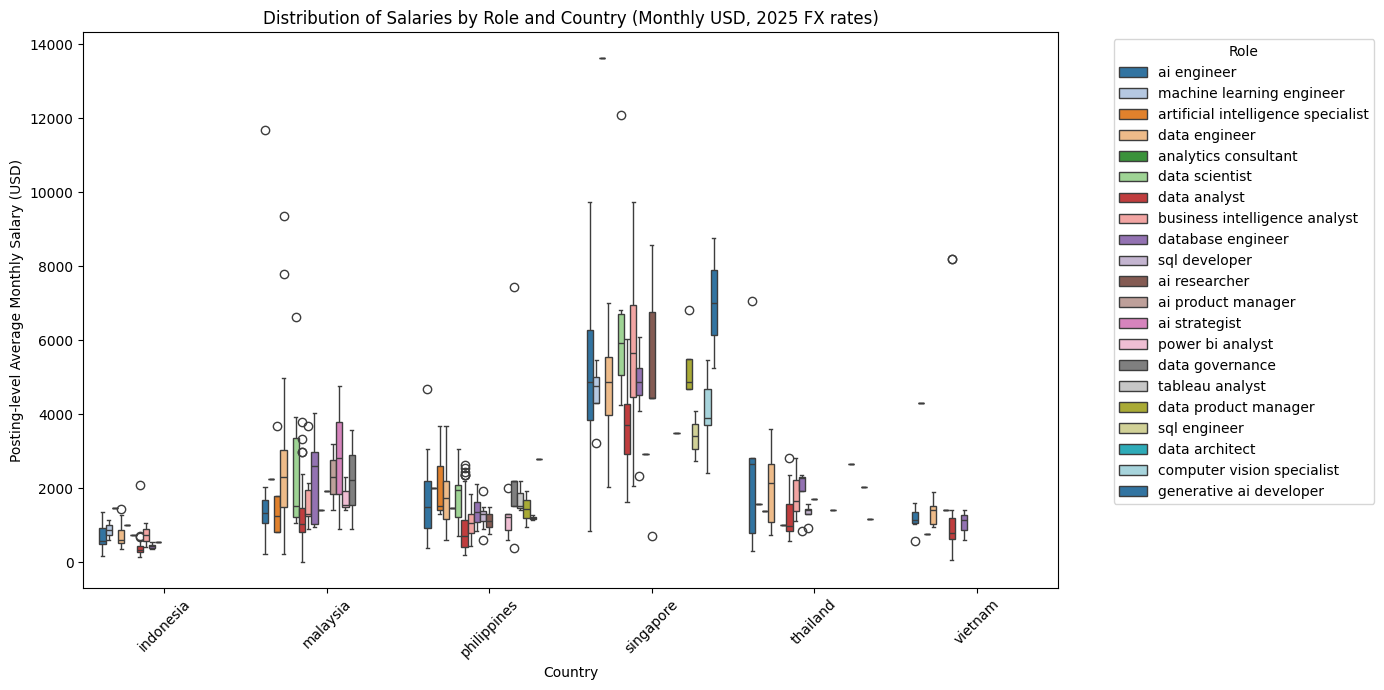

In [99]:
# --- Step 10: Compute descriptive statistics by country × role ---
stats_summary = df_salary.groupby(['country', 'normalized_title'])['salary_avg_usd'].agg(
    count='count',
    mean='mean',
    median='median',
    variance='var',
    min='min',
    max='max'
).reset_index()

# Round numeric columns for readability
stats_summary[['mean','median','variance','min','max']] = stats_summary[['mean','median','variance','min','max']].round(2)

print("Descriptive statistics by country and role:")
print(stats_summary)

# --- Step 11: Boxplot (show outliers) ---
plt.figure(figsize=(14, 7))
palette = sns.color_palette("tab20", n_colors=df_salary['normalized_title'].nunique())

sns.boxplot(
    data=df_salary,
    x='country',
    y='salary_avg_usd',
    hue='normalized_title',
    palette=palette,
    showfliers=True
)
plt.title("Distribution of Salaries by Role and Country (Monthly USD, 2025 FX rates)")
plt.ylabel("Posting-level Average Monthly Salary (USD)")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.legend(title="Role", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<br><br>
**================================================================**

**Hypothesis H5 - Highest Salary**  

H5 (Q1.4): Singapore will have the highest average salary per data job, while Vietnam and the Philippines will have the lowest.

Kruskal-Wallis Test Across Countries: statistic=373.91, p_value=0.0000

Dunn's post-hoc pairwise comparisons (p-values):
                indonesia      malaysia   philippines     singapore  \
indonesia    1.000000e+00  1.966131e-12  7.964612e-07  2.307547e-56   
malaysia     1.966131e-12  1.000000e+00  6.117617e-03  9.160939e-24   
philippines  7.964612e-07  6.117617e-03  1.000000e+00  2.581653e-58   
singapore    2.307547e-56  9.160939e-24  2.581653e-58  1.000000e+00   
thailand     7.959450e-10  1.000000e+00  4.428767e-02  1.282654e-13   
vietnam      9.469595e-04  1.000000e+00  1.000000e+00  1.416081e-16   

                 thailand       vietnam  
indonesia    7.959450e-10  9.469595e-04  
malaysia     1.000000e+00  1.000000e+00  
philippines  4.428767e-02  1.000000e+00  
singapore    1.282654e-13  1.416081e-16  
thailand     1.000000e+00  1.000000e+00  
vietnam      1.000000e+00  1.000000e+00  

Descriptive statistics per country:
             count     mean   median         var  

C:\Users\Marti\AppData\Local\Temp\ipykernel_14676\3932437175.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


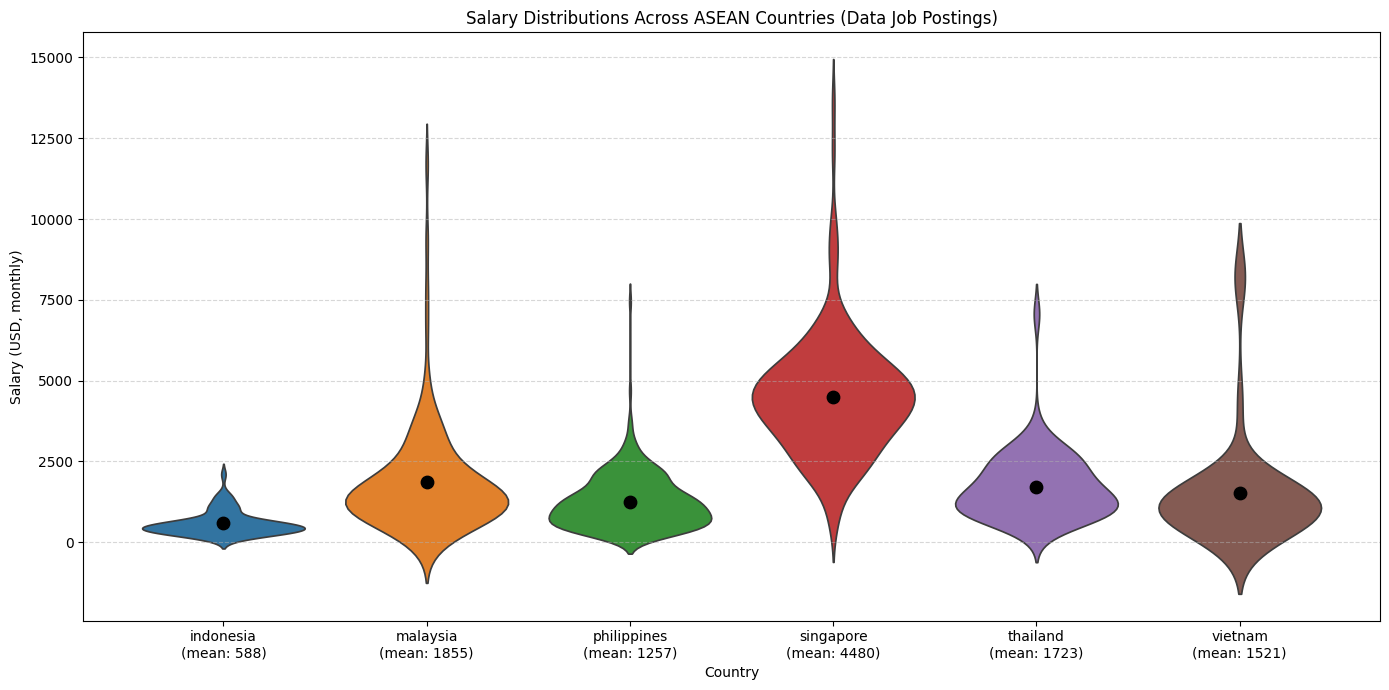

In [100]:
# --- Step 11: Kruskal-Wallis Test Across Countries ---
countries = df_salary['country'].unique()

# Gather salary lists per country
salary_lists = [df_salary[df_salary['country'] == c]['salary_avg_usd'] for c in countries]

# Perform Kruskal-Wallis test
stat, p = kruskal(*salary_lists)
print(f"Kruskal-Wallis Test Across Countries: statistic={stat:.2f}, p_value={p:.4f}")

# --- Optional: Post-hoc Dunn's test for pairwise comparisons ---
dunn_results = sp.posthoc_dunn(df_salary, val_col='salary_avg_usd', group_col='country', p_adjust='bonferroni')
print("\nDunn's post-hoc pairwise comparisons (p-values):")
print(dunn_results)

# --- Descriptive stats per country (to support H5) ---
country_stats = df_salary.groupby('country')['salary_avg_usd'].agg(
    count='count',
    mean='mean',
    median='median',
    var='var',
    min='min',
    max='max'
).round(2).sort_values('mean', ascending=False)

print("\nDescriptive statistics per country:")
print(country_stats)

# --- Step 12: Violin Plot ---
# Assign colors to countries
countries = df_salary['country'].unique()
palette = sns.color_palette("tab10", n_colors=len(countries))
country_colors = dict(zip(countries, palette))

plt.figure(figsize=(14, 7))

# Violin plot per country
sns.violinplot(
    data=df_salary,
    x='country',
    y='salary_avg_usd',
    palette=country_colors,
    inner=None  # Hide quartiles
)

# Overlay mean salary markers
means = df_salary.groupby('country')['salary_avg_usd'].mean()
for i, country in enumerate(countries):
    mean_val = means[country]
    plt.scatter(i, mean_val, color='black', s=80, zorder=10)

# Modify x-axis labels to include mean salary
new_labels = [f"{c}\n(mean: {means[c]:.0f})" for c in countries]
plt.xticks(ticks=range(len(countries)), labels=new_labels)

plt.ylabel("Salary (USD, monthly)")
plt.xlabel("Country")
plt.title("Salary Distributions Across ASEAN Countries (Data Job Postings)")

# Remove duplicate legend
plt.legend([], [], frameon=False)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Descriptive Statistics (Salary in Monthly USD, 2025 FX rates)**

| Country     | Count | Mean   | Median | Variance      | Min     | Max      |
|------------|-------|--------|--------|---------------|---------|----------|
| Singapore  | 167   | 4479.51 | 4442.58 | 3,312,696.70 | 701.46  | 13,639.50 |
| Malaysia   | 125   | 1854.65 | 1406.35 | 2,714,908.18 | 0.83    | 11,691.00 |
| Thailand   | 59    | 1722.90 | 1491.02 | 1,100,169.52 | 313.90  | 7,062.75  |
| Vietnam    | 38    | 1520.65 | 1137.00 | 2,979,368.16 | 75.80   | 8,205.35  |
| Philippines| 269   | 1257.25 | 1139.45 | 712,942.75   | 201.77  | 7,450.25  |
| Indonesia  | 63    | 588.28  | 504.67  | 138,436.14   | 135.18  | 2,102.80  |

- Singapore has the **highest mean and median salaries** (~4,480 USD).  
- **Lowest mean salary** is in **Indonesia** (~588 USD), followed by the Philippines (~1,257 USD) and Vietnam (~1,521 USD).  
- Malaysia and Thailand have intermediate salaries.

---

### **Statistical Treatment**

- Salaries are **skewed**, so a **Kruskal-Wallis H test** was applied.  
- **Result:** H = 373.91, p < 0.0001 → reject H0 → **significant differences in salaries across countries**.  
- **Post-hoc Dunn’s test (pairwise comparisons, p-values)** identifies which country pairs differ significantly:

**Key Dunn’s test highlights (p < 0.05 indicate significant difference):**

- Singapore salaries are significantly higher than all other countries.  
- Indonesia has the **lowest salaries**, significantly different from Singapore, Malaysia, Thailand, and Vietnam.  
- Vietnam and Philippines salaries are higher than Indonesia but significantly lower than Singapore.  
- Malaysia and Thailand occupy an intermediate range.

---

### **Interpretation / Discussion**

- **H1 partially confirmed:** Singapore has the **highest average salary per data job**, as hypothesized.  
- **Lowest-paying country** is actually Indonesia, not Vietnam or the Philippines.  
- Vietnam and the Philippines have low salaries but are **not the absolute lowest**.  
- Intermediate salaries in Malaysia and Thailand reflect moderate-paying roles with some high-end positions.  
- **Boxplot visualization** highlights Singapore’s skew toward high salaries and Indonesia’s low range.  
- **Kruskal-Wallis and Dunn’s tests** confirm that these differences are **statistically significant**.

---

**Key Insight:** ASEAN data job salaries are uneven: **Singapore leads as the top-paying country**, **Indonesia is the lowest**, and the other countries occupy intermediate ranges. This highlights a significant regional disparity in compensation for data roles.